[kaggle 코드 참고-Supreme Court Judgement Prediction](https://www.kaggle.com/code/raghavkachroo/supreme-court-judgement-prediction)

In [2]:
# !pip install xgboost

In [3]:
# !pip install nltk

In [4]:
# !pip install spacy

In [5]:
# !spacy download en

In [6]:
# 토큰화에서 필요
# nltk.download('punkt')

In [7]:
# 임포트

import pandas as pd
import numpy as np

from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report # 평가 지표 확인

# XGBoost : Extreme Gradient Boosting의 약자
# # 기존 Gradient Tree Boosting 알고리즘에 과적합 방지를 위한 기법이 추가된 지도학습 알고리즘

from xgboost import XGBClassifier 
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier

from sklearn.metrics import accuracy_score

import re
import nltk # Natural Language Toolkit 자연어 처리를 위함
import spacy

import os
from tqdm import tqdm

In [8]:
# 파일 경로 파악
for dirname, _, filenames in os.walk('open'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

open/.DS_Store
open/open.zip


In [9]:
# 데이터 로드
df = pd.read_csv('train.csv')
df.head()

,ID,first_party,second_party,facts,first_party_winner
0,TRAIN_0000,Phil A. St. Amant,Herman A. Thompson,"On June 27, 1962, Phil St. Amant, a candidate ...",1
1,TRAIN_0001,Stephen Duncan,Lawrence Owens,Ramon Nelson was riding his bike when he suffe...,0
2,TRAIN_0002,Billy Joe Magwood,"Tony Patterson, Warden, et al.",An Alabama state court convicted Billy Joe Mag...,1
3,TRAIN_0003,Linkletter,Walker,Victor Linkletter was convicted in state court...,0
4,TRAIN_0004,William Earl Fikes,Alabama,"On April 24, 1953 in Selma, Alabama, an intrud...",1


In [10]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2478 entries, 0 to 2477
Data columns (total 5 columns):
 #   Column              Non-Null Count  Dtype 
---  ------              --------------  ----- 
 0   ID                  2478 non-null   object
 1   first_party         2478 non-null   object
 2   second_party        2478 non-null   object
 3   facts               2478 non-null   object
 4   first_party_winner  2478 non-null   int64 
dtypes: int64(1), object(4)
memory usage: 96.9+ KB


In [11]:
# 특수문자 정리
df['facts_replace'] = df['facts'].str.replace(r'<[^<>]*>', '', regex=True)
df

,ID,first_party,second_party,facts,first_party_winner,facts_replace
0,TRAIN_0000,Phil A. St. Amant,Herman A. Thompson,"On June 27, 1962, Phil St. Amant, a candidate ...",1,"On June 27, 1962, Phil St. Amant, a candidate ..."
1,TRAIN_0001,Stephen Duncan,Lawrence Owens,Ramon Nelson was riding his bike when he suffe...,0,Ramon Nelson was riding his bike when he suffe...
2,TRAIN_0002,Billy Joe Magwood,"Tony Patterson, Warden, et al.",An Alabama state court convicted Billy Joe Mag...,1,An Alabama state court convicted Billy Joe Mag...
3,TRAIN_0003,Linkletter,Walker,Victor Linkletter was convicted in state court...,0,Victor Linkletter was convicted in state court...
4,TRAIN_0004,William Earl Fikes,Alabama,"On April 24, 1953 in Selma, Alabama, an intrud...",1,"On April 24, 1953 in Selma, Alabama, an intrud..."
...,...,...,...,...,...,...
2473,TRAIN_2473,"HollyFrontier Cheyenne Refining, LLC, et al.","Renewable Fuels Association, et al.",Congress amended the Clean Air Act through the...,1,Congress amended the Clean Air Act through the...
2474,TRAIN_2474,"Grupo Mexicano de Desarrollo, S. A.","Alliance Bond Fund, Inc.","Alliance Bond Fund, Inc., an investment fund, ...",1,"Alliance Bond Fund, Inc., an investment fund, ..."
2475,TRAIN_2475,Peguero,United States,"In 1992, the District Court sentenced Manuel D...",0,"In 1992, the District Court sentenced Manuel D..."
2476,TRAIN_2476,Immigration and Naturalization Service,St. Cyr,"On March 8, 1996, Enrico St. Cyr, a lawful per...",0,"On March 8, 1996, Enrico St. Cyr, a lawful per..."


In [12]:
# 전체 facts 를 하나로
corpus = df['facts_replace'].str.cat(sep=" ")

# 전체에 대한 토큰화
lst_tokens = nltk.tokenize.word_tokenize(corpus)
lst_tokens

['On',
 'June',
 '27',
 ',',
 '1962',
 ',',
 'Phil',
 'St.',
 'Amant',
 ',',
 'a',
 'candidate',
 'for',
 'public',
 'office',
 ',',
 'made',
 'a',
 'television',
 'speech',
 'in',
 'Baton',
 'Rouge',
 ',',
 'Louisiana',
 '.',
 'During',
 'this',
 'speech',
 ',',
 'St.',
 'Amant',
 'accused',
 'his',
 'political',
 'opponent',
 'of',
 'being',
 'a',
 'Communist',
 'and',
 'of',
 'being',
 'involved',
 'in',
 'criminal',
 'activities',
 'with',
 'the',
 'head',
 'of',
 'the',
 'local',
 'Teamsters',
 'Union',
 '.',
 'Finally',
 ',',
 'St.',
 'Amant',
 'implicated',
 'Herman',
 'Thompson',
 ',',
 'an',
 'East',
 'Baton',
 'Rouge',
 'deputy',
 'sheriff',
 ',',
 'in',
 'a',
 'scheme',
 'to',
 'move',
 'money',
 'between',
 'the',
 'Teamsters',
 'Union',
 'and',
 'St.',
 'Amant',
 '’',
 's',
 'political',
 'opponent',
 '.',
 'Thompson',
 'successfully',
 'sued',
 'St.',
 'Amant',
 'for',
 'defamation',
 '.',
 'Louisiana',
 '’',
 's',
 'First',
 'Circuit',
 'Court',
 'of',
 'Appeals',
 'reve

In [13]:
# 불용어 (I, my, me, to와 같이 분석에 의미없는 빈번한 단어) 제거
# nltk에서 제공해주는 불용어 정의 가져오기
nltk.download('stopwords')

[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/philinggood/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

In [14]:
# 불용어 리스트 저장
lst_stopwords = nltk.corpus.stopwords.words("english")
lst_stopwords

['i',
 'me',
 'my',
 'myself',
 'we',
 'our',
 'ours',
 'ourselves',
 'you',
 "you're",
 "you've",
 "you'll",
 "you'd",
 'your',
 'yours',
 'yourself',
 'yourselves',
 'he',
 'him',
 'his',
 'himself',
 'she',
 "she's",
 'her',
 'hers',
 'herself',
 'it',
 "it's",
 'its',
 'itself',
 'they',
 'them',
 'their',
 'theirs',
 'themselves',
 'what',
 'which',
 'who',
 'whom',
 'this',
 'that',
 "that'll",
 'these',
 'those',
 'am',
 'is',
 'are',
 'was',
 'were',
 'be',
 'been',
 'being',
 'have',
 'has',
 'had',
 'having',
 'do',
 'does',
 'did',
 'doing',
 'a',
 'an',
 'the',
 'and',
 'but',
 'if',
 'or',
 'because',
 'as',
 'until',
 'while',
 'of',
 'at',
 'by',
 'for',
 'with',
 'about',
 'against',
 'between',
 'into',
 'through',
 'during',
 'before',
 'after',
 'above',
 'below',
 'to',
 'from',
 'up',
 'down',
 'in',
 'out',
 'on',
 'off',
 'over',
 'under',
 'again',
 'further',
 'then',
 'once',
 'here',
 'there',
 'when',
 'where',
 'why',
 'how',
 'all',
 'any',
 'both',
 'each

### Stemmer
* 영어에서 동사의 굴절 어미인, -s, -ing, -(e)d 등을 제거하여 say(sai)와 같은 어간(stem)만을 추출한다. 예) eating = eat
* 가끔 쌩뚱맞은 단어로 변형할 수 있다. 예) caring -> car, care가 car가 돼버린다. 영어는 복잡하다.
* 토큰화 여부 상관 없음
* 출처 : https://www.projectpro.io/recipes/use-porter-stemmer
```python
ps = nltk.stem.porter.PorterStemmer()
```

### Lemmatizer
* 영단어에 굴절이 일어나기 이전의 원형을 'lemma'라고 하며 lemma로 복원하는 작업이다. 예) caring -> care, said -> say
* PorterStemmer 보다는 조금 더 유의미하게 변형시켜준다. 하지만 단어형태를 바꾸진 않는다. 예) are -> are
* 토큰화 하고 해야함
* 출처 : https://www.machinelearningplus.com/nlp/lemmatization-examples-python/
```python
lem = nltk.stem.wordnet.WordNetLemmatizer()
```

### spacy
* spacy는 위의 방법들 보다는 더 단어의 원형태로 변형시켜준다. 예) are -> be
* 단 pronouns(대명사)는 -PRON-으로 나타냄을 볼 수 있다.
* 토큰화 하고 해야함
* 출처 : https://www.machinelearningplus.com/nlp/lemmatization-examples-python/
```python
scy = spacy.load('en_core_web_sm', disable=['parser','ner'])

# 예제
sentence = "The striped bats are hanging on their feet for best"

# Parse the sentence using the loaded 'en' model object `nlp`
doc = nlp(sentence)

# Extract the lemma for each token and join
" ".join([token.lemma_ for token in doc])
#> 'the strip bat be hang on -PRON- foot for good'
```

## spacy -> stemming & lemmatisation 하기

### spacy 적용 코드 여러가지 작성하다가 가장 간단한 한 줄(방법4) 채택
```python
def spacy_preprocessing(sentence):
    # Parse the sentence using the loaded 'en' model object `nlp`
    doc = nlp(sentence)

    # Extract the lemma for each token and join
    text = " ".join([token.lemma_ for token in doc])
    #> 'the strip bat be hang on -PRON- foot for good'
    return text

# 방법 1
# 함수에 str로 바로 넣기, list 저장 후 df로 추가
new_sentence = []
for sentence in tqdm(df['facts_clean']):
    new_sentence.append(spacy_preprocessing(sentence))
df['facts_spacy'] = new_sentence

# 방법 2
# index 로 받아서 df에 하나씩 변환하여 추가
for i in range(len(df)):
    df.loc[i, 'facts_spacy'] = spacy_preprocessing(df.loc[i, 'facts_clean'])

# 방법 3
# 하나씩 "함수" 적용해서 추가
df['facts_new'] = df['facts_clean'].apply(lambda x: spacy_preprocessing(x))

# 방법 4
# 하나씩 적용해서 추가 (함수 없이)
df['facts_done'] = df['facts_clean'].apply(lambda x: " ".join([token.lemma_ for token in nlp(x)]))
```

In [15]:
nltk.download('wordnet')

[nltk_data] Downloading package wordnet to
[nltk_data]     /Users/philinggood/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


True

In [16]:
# 모델 정의
nlp = spacy.load("en_core_web_sm", disable=['parser', 'ner'])

df['facts_spacy'] = df['facts_replace'].apply(lambda x: " ".join([token.lemma_ for token in nlp(x)]))

In [17]:
# 토큰화, stemming, lemmatisation
def utils_preprocess_text(text, flg_stemm=False, flg_lemm=True, lst_stopwords=None):
    # 전처리: 특수문자 삭제, string, 소문자화, 공백 제거 
    text = re.sub(r'[^\w\s]', '', str(text).lower().strip())

    # 토큰화 str -> list
    lst_text = text.split()
    
    # 불용어 제거
    if lst_stopwords is not None: 
        lst_text = [word for word in lst_text if word not in 
                    lst_stopwords]

    ## Stemming (remove -ing, -ly, -ed, ...)
    if flg_stemm == True:
        ps = nltk.stem.porter.PorterStemmer()
        lst_text = [ps.stem(word) for word in lst_text]

    ## Lemmatisation (convert the word into root word)
    if flg_lemm == True:
        lem = nltk.stem.wordnet.WordNetLemmatizer()
        lst_text = [lem.lemmatize(word) for word in lst_text]

    ## list -> str
    text = " ".join(lst_text)
    return text

In [18]:
df['facts_clean'] = \
df['facts_spacy'].apply(lambda x: \
                        utils_preprocess_text(x, flg_stemm=False, \
                                              flg_lemm=True, lst_stopwords=lst_stopwords))
df['facts_clean']

0       june 27 1962 phil st amant candidate public of...
1       ramon nelson ride bike suffer lethal blow back...
2       alabama state court convict billy joe magwood ...
3       victor linkletter convict state court evidence...
4       april 24 1953 selma alabama intruder break apa...
                              ...                        
2473    congress amend clean air act energy policy act...
2474    alliance bond fund inc investment fund purchas...
2475    1992 district court sentence manuel peguero 27...
2476    march 8 1996 enrico st cyr lawful permanent re...
2477    herbert markman patent system track clothing d...
Name: facts_clean, Length: 2478, dtype: object

In [19]:
df

,ID,first_party,second_party,facts,first_party_winner,facts_replace,facts_spacy,facts_clean
0,TRAIN_0000,Phil A. St. Amant,Herman A. Thompson,"On June 27, 1962, Phil St. Amant, a candidate ...",1,"On June 27, 1962, Phil St. Amant, a candidate ...","on June 27 , 1962 , Phil St. Amant , a candida...",june 27 1962 phil st amant candidate public of...
1,TRAIN_0001,Stephen Duncan,Lawrence Owens,Ramon Nelson was riding his bike when he suffe...,0,Ramon Nelson was riding his bike when he suffe...,Ramon Nelson be ride his bike when he suffer a...,ramon nelson ride bike suffer lethal blow back...
2,TRAIN_0002,Billy Joe Magwood,"Tony Patterson, Warden, et al.",An Alabama state court convicted Billy Joe Mag...,1,An Alabama state court convicted Billy Joe Mag...,an Alabama state court convict Billy Joe Magwo...,alabama state court convict billy joe magwood ...
3,TRAIN_0003,Linkletter,Walker,Victor Linkletter was convicted in state court...,0,Victor Linkletter was convicted in state court...,Victor Linkletter be convict in state court on...,victor linkletter convict state court evidence...
4,TRAIN_0004,William Earl Fikes,Alabama,"On April 24, 1953 in Selma, Alabama, an intrud...",1,"On April 24, 1953 in Selma, Alabama, an intrud...","on April 24 , 1953 in Selma , Alabama , an int...",april 24 1953 selma alabama intruder break apa...
...,...,...,...,...,...,...,...,...
2473,TRAIN_2473,"HollyFrontier Cheyenne Refining, LLC, et al.","Renewable Fuels Association, et al.",Congress amended the Clean Air Act through the...,1,Congress amended the Clean Air Act through the...,Congress amend the Clean Air Act through the E...,congress amend clean air act energy policy act...
2474,TRAIN_2474,"Grupo Mexicano de Desarrollo, S. A.","Alliance Bond Fund, Inc.","Alliance Bond Fund, Inc., an investment fund, ...",1,"Alliance Bond Fund, Inc., an investment fund, ...","Alliance Bond Fund , Inc. , an investment fund...",alliance bond fund inc investment fund purchas...
2475,TRAIN_2475,Peguero,United States,"In 1992, the District Court sentenced Manuel D...",0,"In 1992, the District Court sentenced Manuel D...","in 1992 , the District Court sentence Manuel D...",1992 district court sentence manuel peguero 27...
2476,TRAIN_2476,Immigration and Naturalization Service,St. Cyr,"On March 8, 1996, Enrico St. Cyr, a lawful per...",0,"On March 8, 1996, Enrico St. Cyr, a lawful per...","on March 8 , 1996 , Enrico St. Cyr , a lawful ...",march 8 1996 enrico st cyr lawful permanent re...


In [20]:
df['facts'][0]

'On June 27, 1962, Phil St. Amant, a candidate for public office, made a television speech in Baton Rouge, Louisiana.  During this speech, St. Amant accused his political opponent of being a Communist and of being involved in criminal activities with the head of the local Teamsters Union.  Finally, St. Amant implicated Herman Thompson, an East Baton Rouge deputy sheriff, in a scheme to move money between the Teamsters Union and St. Amant’s political opponent. \nThompson successfully sued St. Amant for defamation.  Louisiana’s First Circuit Court of Appeals reversed, holding that Thompson did not show St. Amant acted with “malice.”  Thompson then appealed to the Supreme Court of Louisiana.  That court held that, although public figures forfeit some of their First Amendment protection from defamation, St. Amant accused Thompson of a crime with utter disregard of whether the remarks were true.  Finally, that court held that the First Amendment protects uninhibited, robust debate, rather t

In [21]:
df.loc[0, 'facts_replace']

'On June 27, 1962, Phil St. Amant, a candidate for public office, made a television speech in Baton Rouge, Louisiana.  During this speech, St. Amant accused his political opponent of being a Communist and of being involved in criminal activities with the head of the local Teamsters Union.  Finally, St. Amant implicated Herman Thompson, an East Baton Rouge deputy sheriff, in a scheme to move money between the Teamsters Union and St. Amant’s political opponent. \nThompson successfully sued St. Amant for defamation.  Louisiana’s First Circuit Court of Appeals reversed, holding that Thompson did not show St. Amant acted with “malice.”  Thompson then appealed to the Supreme Court of Louisiana.  That court held that, although public figures forfeit some of their First Amendment protection from defamation, St. Amant accused Thompson of a crime with utter disregard of whether the remarks were true.  Finally, that court held that the First Amendment protects uninhibited, robust debate, rather t

In [22]:
df.loc[0, 'facts_spacy']

'on June 27 , 1962 , Phil St. Amant , a candidate for public office , make a television speech in Baton Rouge , Louisiana .   during this speech , St. Amant accuse his political opponent of be a Communist and of be involve in criminal activity with the head of the local Teamsters Union .   finally , St. Amant implicate Herman Thompson , an East Baton Rouge deputy sheriff , in a scheme to move money between the Teamsters Union and St. Amant ’s political opponent . \n Thompson successfully sue St. Amant for defamation .   Louisiana ’s First Circuit Court of Appeals reverse , hold that Thompson do not show St. Amant act with " malice . "   Thompson then appeal to the Supreme Court of Louisiana .   that court hold that , although public figure forfeit some of their First Amendment protection from defamation , St. Amant accuse Thompson of a crime with utter disregard of whether the remark be true .   finally , that court hold that the First Amendment protect uninhibited , robust debate , ra

In [23]:
df.loc[0,'facts_clean']

'june 27 1962 phil st amant candidate public office make television speech baton rouge louisiana speech st amant accuse political opponent communist involve criminal activity head local teamster union finally st amant implicate herman thompson east baton rouge deputy sheriff scheme move money teamster union st amant political opponent thompson successfully sue st amant defamation louisiana first circuit court appeal reverse hold thompson show st amant act malice thompson appeal supreme court louisiana court hold although public figure forfeit first amendment protection defamation st amant accuse thompson crime utter disregard whether remark true finally court hold first amendment protect uninhibited robust debate rather open season shoot good name anyone happen public servant'

In [24]:
# 시각화
import matplotlib.pyplot as plt
from matplotlib.pyplot import figure

In [25]:
!pip install matplotlib

In [26]:
# 많이 사용된 단어 출력
def plot_word(label):
    corpus = df[df["first_party_winner"]== label]["facts_clean"]
    lst_tokens = nltk.tokenize.word_tokenize(corpus.str.cat(sep=" "))
    fig, ax = plt.subplots(nrows=2, ncols=1)
    fig.suptitle("Most frequent words", fontsize=15)
    figure(figsize=(30, 24))

    # unigrams : 한 단어
    dic_words_freq = nltk.FreqDist(lst_tokens)
    dtf_uni = pd.DataFrame(dic_words_freq.most_common(), 
                           columns=["Word","Freq"])
    dtf_uni.set_index("Word").iloc[:10,:].sort_values(by="Freq").plot(
                      kind="barh", title="Unigrams", ax=ax[0], 
                      legend=False).grid(axis='x')
    ax[0].set(ylabel=None)

    # bigrams : 두 단어
    dic_words_freq = nltk.FreqDist(nltk.ngrams(lst_tokens, 2))
    dtf_bi = pd.DataFrame(dic_words_freq.most_common(), 
                          columns=["Word","Freq"])
    dtf_bi["Word"] = dtf_bi["Word"].apply(lambda x: " ".join(
                       string for string in x) )
    dtf_bi.set_index("Word").iloc[:10,:].sort_values(by="Freq").plot(
                      kind="barh", title="Bigrams", ax=ax[1],
                      legend=False).grid(axis='x')
    ax[1].set(ylabel=None)
    plt.show()

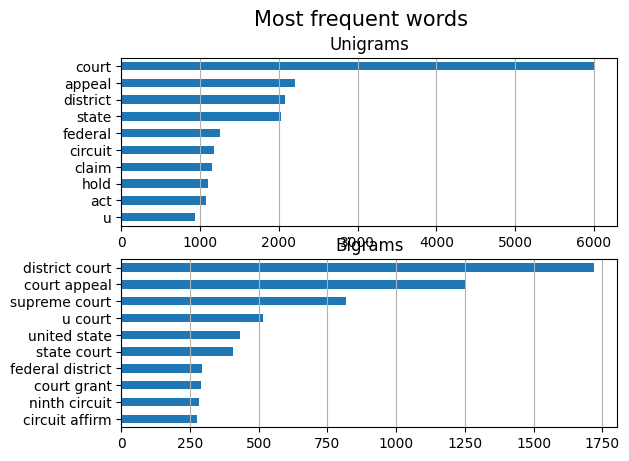

<Figure size 3000x2400 with 0 Axes>

In [27]:
# first_party 가 1 승소
plot_word(1)

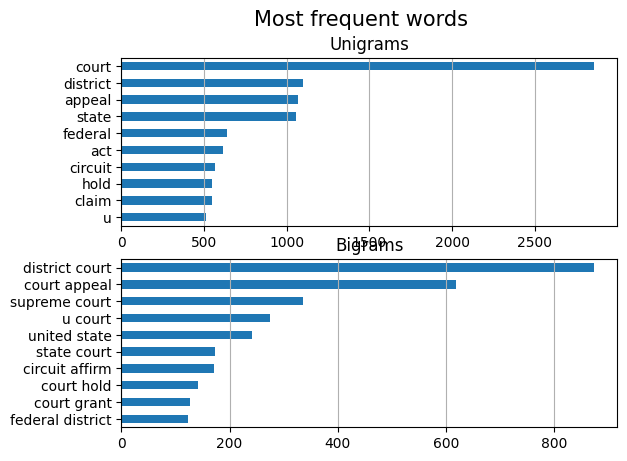

<Figure size 3000x2400 with 0 Axes>

In [28]:
# first_party 가 0 패소
plot_word(0)

In [29]:
!pip install wordcloud

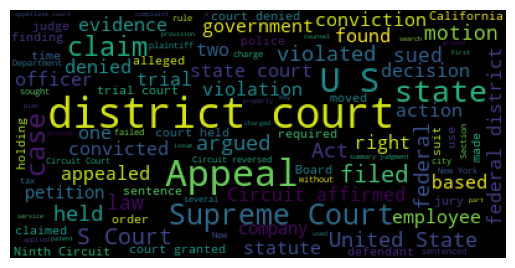

In [30]:
import wordcloud
wc = wordcloud.WordCloud(background_color='black', max_words=100, 
                         max_font_size=35)
wc = wc.generate(str(corpus))
fig = plt.figure(num=1)
plt.axis('off')
plt.imshow(wc, cmap=None)
plt.show()

In [31]:
!pip install gensim

In [32]:
!pip install seaborn

In [33]:
import gensim.downloader as gensim_api
import gensim
import seaborn as sns

In [34]:
def plot_MainTopic(label):
    corpus = df[df["first_party_winner"]==label]["facts_clean"]
    ## pre-process corpus
    lst_corpus = []
    for string in corpus:
        lst_words = string.split()
        lst_grams = [" ".join(lst_words[i:i + 2]) for i in range(0, 
                         len(lst_words), 2)]
        lst_corpus.append(lst_grams)## map words to an id
    id2word = gensim.corpora.Dictionary(lst_corpus)## create dictionary word:freq
    dic_corpus = [id2word.doc2bow(word) for word in lst_corpus] ## train LDA
    lda_model = gensim.models.ldamodel.LdaModel(corpus=dic_corpus, id2word=id2word, num_topics=7, random_state=123, update_every=1, chunksize=100, passes=10, alpha='auto', per_word_topics=True)

    ## output
    lst_dics = []
    for i in range(0,3):
        lst_tuples = lda_model.get_topic_terms(i)
        for tupla in lst_tuples:
            lst_dics.append({"topic":i, "id":tupla[0], 
                             "word":id2word[tupla[0]], 
                             "weight":tupla[1]})
    dtf_topics = pd.DataFrame(lst_dics, 
                             columns=['topic','id','word','weight'])

    ## plot
    fig, ax = plt.subplots()
    sns.barplot(y="word", x="weight", hue="topic", data=dtf_topics, dodge=False, ax=ax).set_title('Main Topics')
    ax.set(ylabel="", xlabel="Word Importance")
    plt.show()

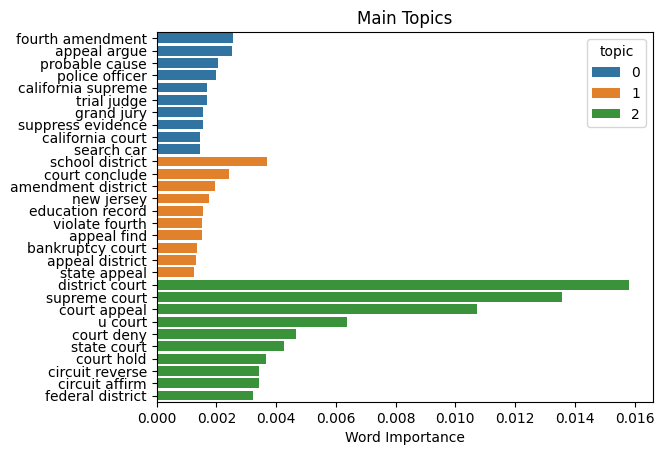

In [35]:
# first_party 가 1 승소
plot_MainTopic(1)

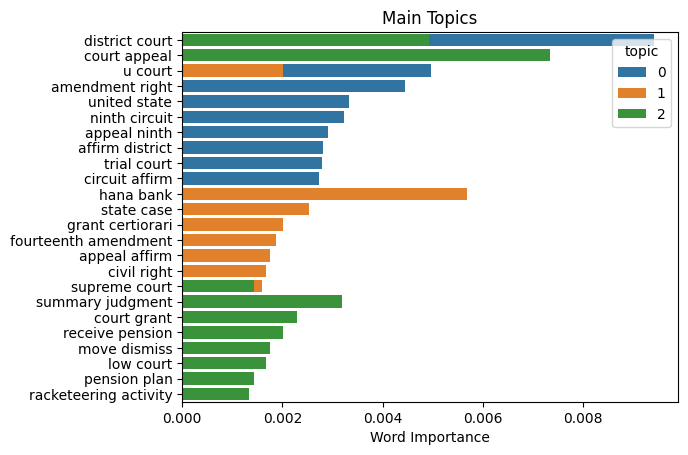

In [36]:
# first_party 가 0 패소
plot_MainTopic(0)

## 드디어 머신러닝 돌림
* 일단 pipeline 단계 생략함

In [37]:
# 데이터 로드
df_train = df.copy()
df_test = pd.read_csv('test.csv')

### TfidfVectorizer

In [38]:
# 단어 빈도수 카운트 하여, 카운트한 내용으로 선형회귀 모델 학습 -> 1/0을 구함
from sklearn.feature_extraction.text import TfidfVectorizer # 단어의 한 문서내 빈도수, 전체 문서 빈도수를 계산하여 최종 단어 빈도수 계산해주는 알고리즘
from sklearn.linear_model import LogisticRegression # 선형 회귀

In [39]:
# 데이터 처리

# 모델링
vectorizer = TfidfVectorizer()

# 데이터 처리 함수 생성
def get_vector(verctorizer, df, train_mode):
    if train_mode:
        X_facts = vectorizer.fit_transform(df['facts'])
    else:
        X_facts = vectorizer.transform(df['facts'])
    X_party1 = vectorizer.transform(df['first_party'])
    X_party2 = vectorizer.transform(df['second_party'])
    
    # csr_matrix -> matrix 로 변환해줌
    # concatenate : 배열 합치기 / axis=0(위->아래), axis=1(좌->우)
    X = np.concatenate([X_party1.todense(),
                       X_party2.todense(),
                       X_facts.todense(),], axis=1)
    return X

In [40]:
X_train = get_vector(vectorizer, df_train, True)
Y_train = df_train["first_party_winner"]
X_test = get_vector(vectorizer, df_test, False)

X = np.asarray(X_train)
Y = np.asarray(Y_train)
X_test = np.asarray(X_test)

In [41]:
x_train, x_val, y_train, y_val = train_test_split(X, Y, test_size = 0.2, random_state = 0)

### LogisticRegression

In [45]:
# 회귀 모델 학습
model = LogisticRegression()
model.fit(x_train, y_train)

print('train score :', model.score(x_train, y_train))
print('val score :',model.score(x_val, y_val))

train score : 0.9233097880928355
val score : 0.6169354838709677


### Random Forest Classifier

In [46]:
from sklearn.ensemble import RandomForestClassifier

rfc = RandomForestClassifier()
rfc.fit(x_train, y_train)

print('train score :', rfc.score(x_train, y_train))
print('val score :',rfc.score(x_val, y_val))

train score : 1.0
val score : 0.6290322580645161


### KNeighbor Classifier

In [47]:
knn = KNeighborsClassifier()
knn.fit(x_train, y_train)

print('train score :', knn.score(x_train, y_train))
print('val score :',knn.score(x_val, y_val))

train score : 0.7250252270433906
val score : 0.6129032258064516


In [ ]:
# 예측하여 제출용 csv 생성

# 기존 샘플 csv 형식 위에 작성
# submit_lr = pd.read_csv('open/sample_submission.csv')

# 예측
y_pred = model_lr.predict(X_test)
model_lr.score(X_test)

In [ ]:
# # 예측한 결과 대입하기
# submit_lr['first_party_winner'] = y_pred
# # 결과 csv로 저장
# submit_lr.to_csv('data/Tfidf_Logistic0.csv', index=False)
# print('Done')

### RandomForestClassifier

In [ ]:
from sklearn.ensemble import RandomForestClassifier

In [ ]:
model_frc = RandomForestClassifier()
model_frc.fit(X_train, Y_train)

In [ ]:
# 예측하여 제출용 csv 생성

# 기존 샘플 csv 형식 위에 작성
# submit_frc = pd.read_csv('open/sample_submission.csv')

# 예측
y_pred = model_frc.predict(X_test)

In [ ]:
# # 예측한 결과 대입하기
# submit_frc['first_party_winner'] = y_pred
# # 결과 csv로 저장
# submit_frc.to_csv('data/Tfidf_RandomForest0.csv', index=False)
# print('Done')

### KNeighborsClassifier

In [ ]:
from sklearn.neighbors import KNeighborsClassifier

In [ ]:
model_knn = KNeighborsClassifier()
model_knn.fit(X_train, Y_train)

In [ ]:
# 예측하여 제출용 csv 생성

# 기존 샘플 csv 형식 위에 작성
# submit_knn = pd.read_csv('open/sample_submission.csv')

# 예측
y_pred = model_knn.predict(X_test)

In [ ]:
# # 예측한 결과 대입하기
# submit_knn['first_party_winner'] = y_pred
# # 결과 csv로 저장
# submit_knn.to_csv('data/Tfidf_KNeighbors0.csv', index=False)
# print('Done')

In [ ]:
# 모델 학습 좀 더 봐주기
### 9. 핫인코딩 부분